In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load engineered dataset (or original if engineered doesn't exist)
try:
    df = pd.read_excel('engineered_features.xlsx')
    print('✓ Loaded engineered dataset')
except:
    df = pd.read_csv('train_A.csv')
    print('✓ Loaded original dataset')

TARGET = 'is_late'
print(f'\nDataset shape: {df.shape}')

✓ Loaded original dataset

Dataset shape: (3000, 19)


CORRELATION ANALYSIS:
Numeric columns analyzed: 10


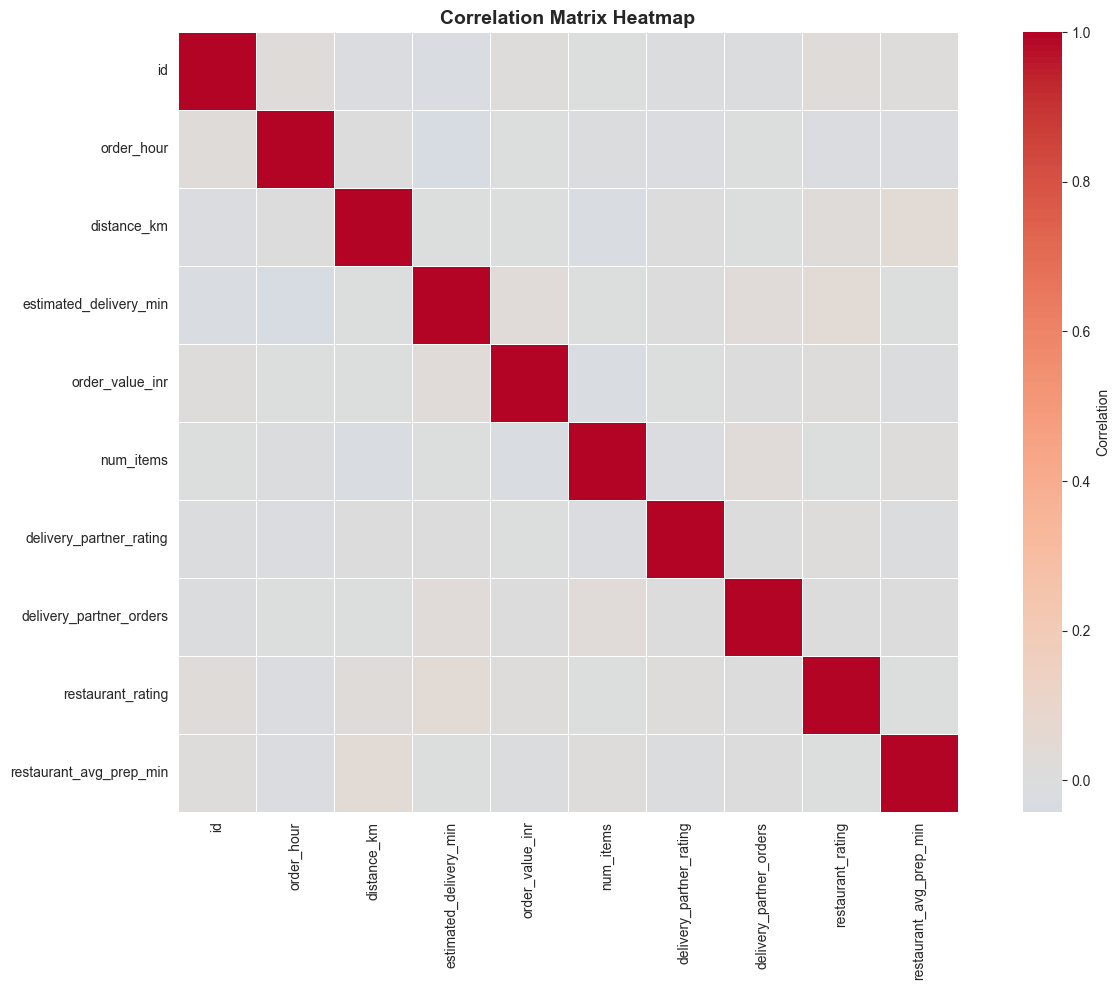


High Correlations (|r| > 0.7, excluding self-correlations):
  No unexpectedly high correlations found.


In [2]:
# Select numeric columns only
numeric_df = df.select_dtypes(include=[np.number])
print('='*60)
print('CORRELATION ANALYSIS:')
print('='*60)
print(f'Numeric columns analyzed: {numeric_df.shape[1]}')

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find high correlations (excluding self-correlations)
print('\nHigh Correlations (|r| > 0.7, excluding self-correlations):')
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            high_corr_pairs.append((col1, col2, corr_val))
            print(f'  {col1} ↔ {col2}: {corr_val:.4f}')

if not high_corr_pairs:
    print('  No unexpectedly high correlations found.')

# Correlation with target variable
if TARGET in numeric_df.columns:
    target_corr = corr_matrix[TARGET].sort_values(ascending=False)
    print('\n' + '='*60)
    print('CORRELATION WITH TARGET VARIABLE:')
    print('='*60)
    print(target_corr.head(10).to_string())

In [3]:
# Outlier Detection using IQR Method
print('\n' + '='*60)
print('OUTLIER DETECTION (IQR METHOD):')
print('='*60)

from sklearn.ensemble import IsolationForest

df_before_outlier = df.copy()
numeric_cols = numeric_df.columns.tolist()

# IQR Method
outlier_count_iqr = 0
outlier_indices = set()

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
    outlier_indices.update(col_outliers)
    outlier_count_iqr += len(col_outliers)
    
    if len(col_outliers) > 0:
        print(f'{col}: Found {len(col_outliers)} outliers [Bounds: {lower_bound:.2f} to {upper_bound:.2f}]')

print(f'\nTotal outlier records found (IQR): {len(outlier_indices)}')

# Isolation Forest for additional outlier detection
print('\nApplying Isolation Forest for anomaly detection...')
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_predictions = iso_forest.fit_predict(numeric_df.fillna(0))
iso_outliers = df.index[outlier_predictions == -1]
print(f'Anomalies detected: {len(iso_outliers)}')

# Remove outliers
combined_outliers = outlier_indices.union(set(iso_outliers))
df_clean = df.drop(combined_outliers)

print(f'\n✓ Total outliers removed: {len(combined_outliers)}')
print(f'Records before: {len(df_before_outlier)}')
print(f'Records after: {len(df_clean)}')
print(f'Data retention: {(len(df_clean) / len(df_before_outlier)) * 100:.2f}%')


OUTLIER DETECTION (IQR METHOD):
delivery_partner_rating: Found 4 outliers [Bounds: 1.80 to 5.80]
restaurant_rating: Found 10 outliers [Bounds: 2.10 to 5.30]
restaurant_avg_prep_min: Found 9 outliers [Bounds: -6.45 to 49.95]

Total outlier records found (IQR): 23

Applying Isolation Forest for anomaly detection...
Anomalies detected: 150

✓ Total outliers removed: 168
Records before: 3000
Records after: 2832
Data retention: 94.40%


CREATING VISUALIZATIONS:


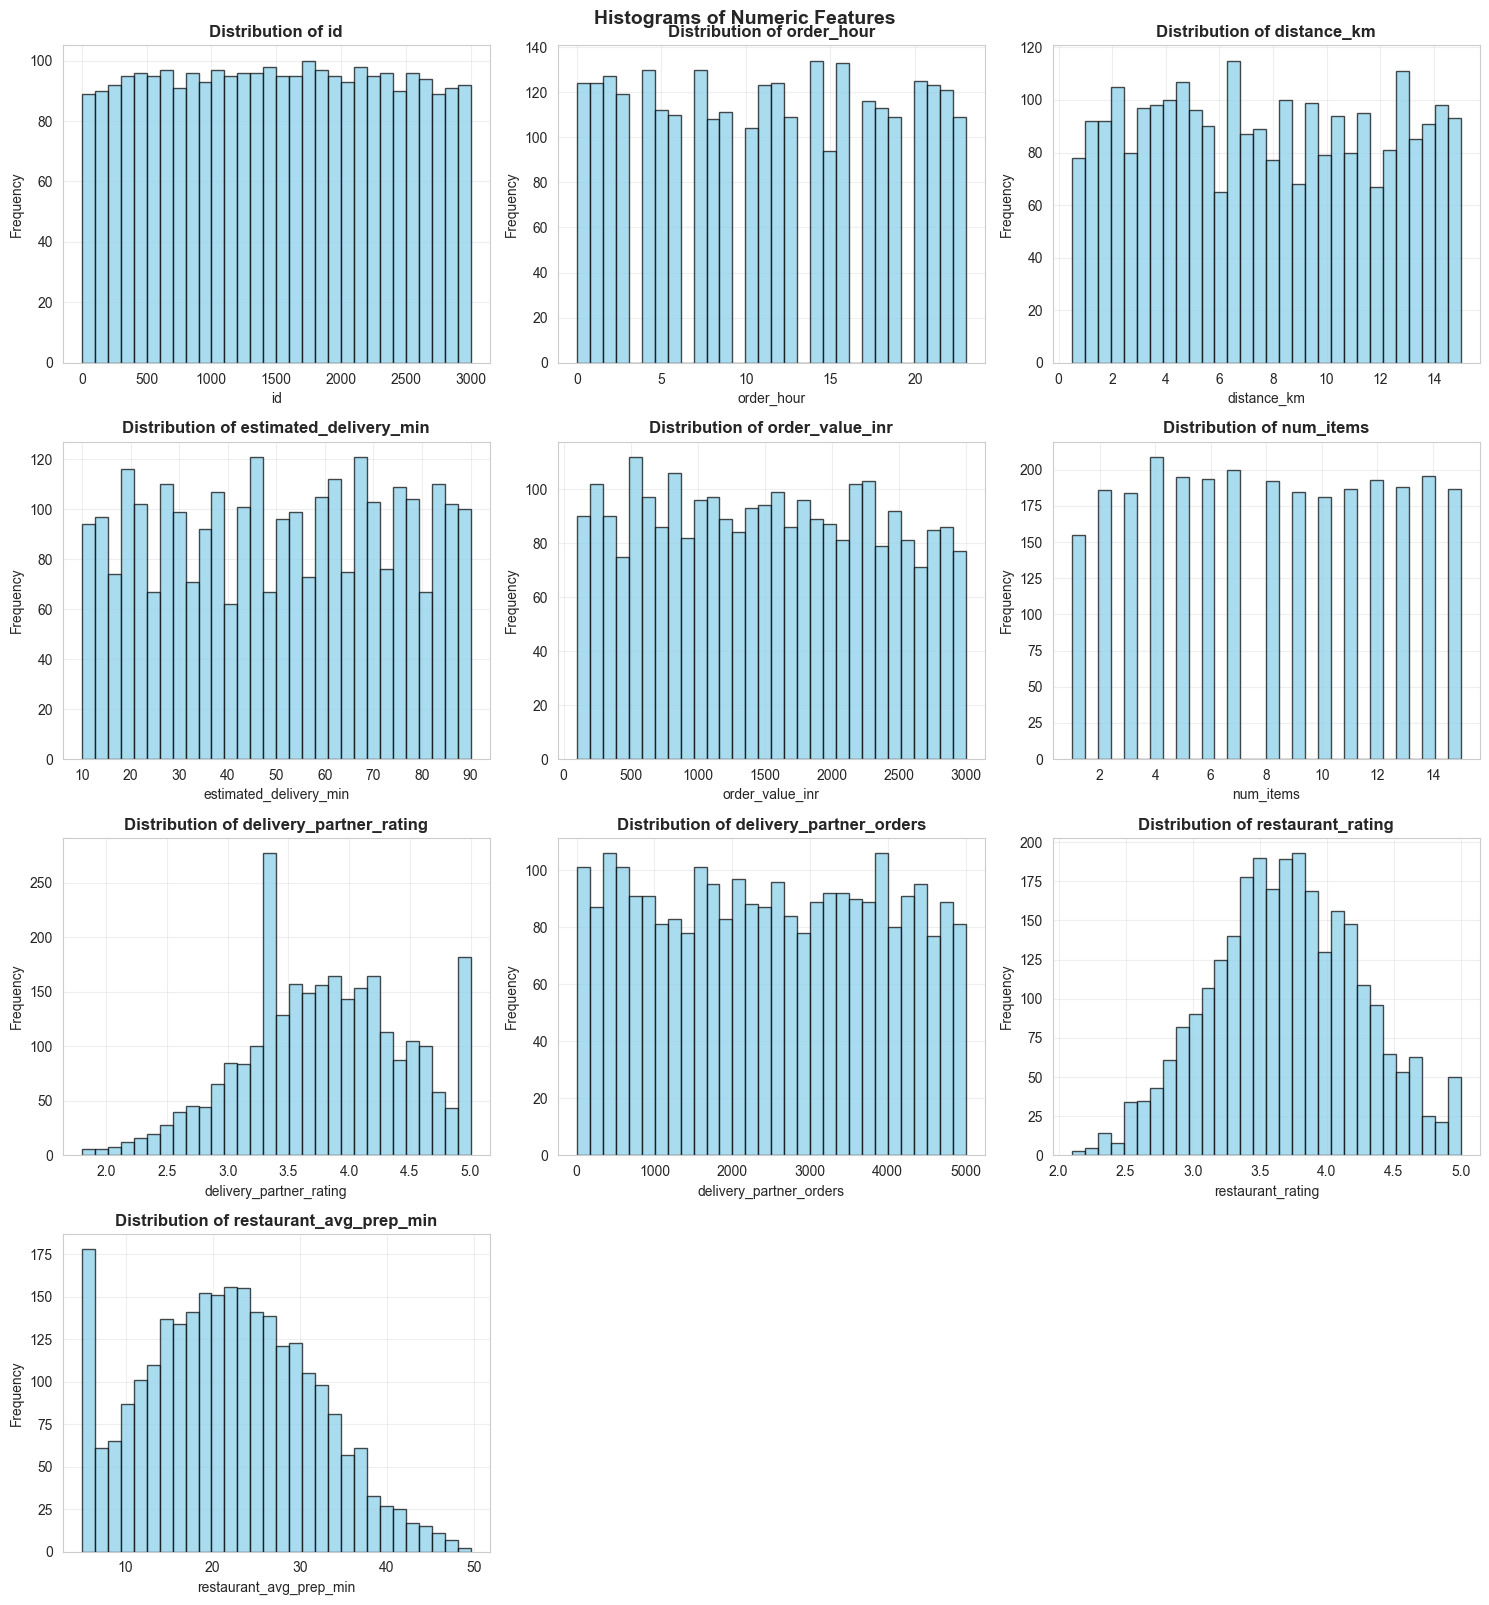

✓ Histograms created for 10 features


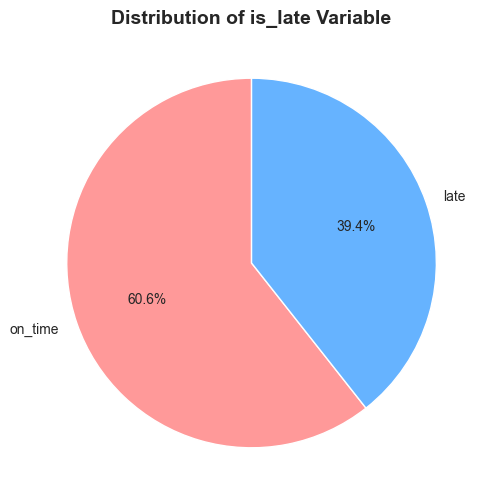

✓ Pie chart created for target variable
SKEWNESS ANALYSIS AND TRANSFORMATIONS:

Top 10 Most Skewed Features:
                 Column  Skewness
delivery_partner_rating -0.186220
restaurant_avg_prep_min  0.173070
            distance_km  0.049662
        order_value_inr  0.041080
 estimated_delivery_min -0.027635
              num_items  0.012368
delivery_partner_orders  0.007475
             order_hour  0.007420
      restaurant_rating -0.005599
                     id -0.000057

Highly skewed features (|skewness| > 1): 0


In [4]:
# Visualizations
print('='*60)
print('CREATING VISUALIZATIONS:')
print('='*60)

# Select numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# 1. Histograms for numeric features
n_cols = min(len(numeric_cols), 12)
n_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols[:n_cols]):
    axes[idx].hist(df_clean[col].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

# Hide unused subplots
for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Histograms of Numeric Features', fontsize=14, fontweight='bold', y=1.00)
plt.show()

print(f'✓ Histograms created for {n_cols} features')

# 2. Pie chart for target variable (if categorical)
if TARGET in df_clean.columns:
    target_counts = df_clean[TARGET].value_counts()
    plt.figure(figsize=(8, 6))
    plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', 
            colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'][:len(target_counts)], startangle=90)
    plt.title(f'Distribution of {TARGET} Variable', fontsize=14, fontweight='bold')
    plt.show()
    print(f'✓ Pie chart created for target variable')# Skewness Analysis
print('='*60)
print('SKEWNESS ANALYSIS AND TRANSFORMATIONS:')
print('='*60)

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
skewness_data = []

for col in numeric_cols:
    if col != TARGET and df_clean[col].nunique() > 10:  # Only for continuous features
        skewness = df_clean[col].skew()
        skewness_data.append({'Column': col, 'Skewness': skewness})

skewness_df = pd.DataFrame(skewness_data).sort_values('Skewness', key=abs, ascending=False)
print('\nTop 10 Most Skewed Features:')
print(skewness_df.head(10).to_string(index=False))

# Select highly skewed features for transformation
highly_skewed = skewness_df[skewness_df['Skewness'].abs() > 1]['Column'].tolist()
print(f'\nHighly skewed features (|skewness| > 1): {len(highly_skewed)}')

# Create transformations for visualization
if highly_skewed:
    fig, axes = plt.subplots(len(highly_skewed[:4]), 4, figsize=(16, 4 * min(4, len(highly_skewed))))
    if len(highly_skewed) <= 4:
        axes = axes.reshape(1, -1) if len(highly_skewed) > 1 else axes.reshape(1, 1)
    
    for idx, col in enumerate(highly_skewed[:4]):
        col_data = df_clean[col].dropna()
        col_data_positive = col_data[col_data > 0]  # For log and reciprocal
        
        # Original
        axes[idx, 0].hist(col_data, bins=20, color='skyblue', edgecolor='black')
        axes[idx, 0].set_title(f'{col} (Original)\nSkewness: {col_data.skew():.3f}')
        
        # Log transformation
        if len(col_data_positive) > 0:
            log_data = np.log(col_data_positive)
            axes[idx, 1].hist(log_data, bins=20, color='lightgreen', edgecolor='black')
            axes[idx, 1].set_title(f'{col} (Log)\nSkewness: {log_data.skew():.3f}')
        
        # Square root transformation
        if len(col_data_positive) > 0:
            sqrt_data = np.sqrt(col_data_positive)
            axes[idx, 2].hist(sqrt_data, bins=20, color='lightcoral', edgecolor='black')
            axes[idx, 2].set_title(f'{col} (√)\nSkewness: {sqrt_data.skew():.3f}')
        
        # Reciprocal transformation
        if len(col_data_positive) > 0:
            reciprocal_data = 1 / col_data_positive
            axes[idx, 3].hist(reciprocal_data, bins=20, color='lightyellow', edgecolor='black')
            axes[idx, 3].set_title(f'{col} (1/x)\nSkewness: {reciprocal_data.skew():.3f}')
    
    plt.tight_layout()
    plt.suptitle('Skewness Analysis and Transformations', fontsize=14, fontweight='bold', y=1.00)
    plt.show()
    print('\n✓ Transformation visualizations created')

In [5]:
# Data Scaling
print('='*60)
print('DATA SCALING:')
print('='*60)

df_scaled = df_clean.copy()
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Remove target from scaling
if TARGET in numeric_cols:
    numeric_cols_to_scale = [col for col in numeric_cols if col != TARGET]
else:
    numeric_cols_to_scale = numeric_cols

scaler = StandardScaler()
df_scaled[numeric_cols_to_scale] = scaler.fit_transform(df_clean[numeric_cols_to_scale])

print(f'\n✓ Scaled {len(numeric_cols_to_scale)} numeric features')
print('\nScaled Data Statistics:')

for col in numeric_cols_to_scale[:5]:  # Show first 5
    print(f'{col}: Mean={df_scaled[col].mean():.4f}, Std={df_scaled[col].std():.4f}, Min={df_scaled[col].min():.4f}, Max={df_scaled[col].max():.4f}')

print('...')

# Save scaled dataset
try:
    df_scaled.to_csv('scaled_eda_data.csv', index=False)
    print('\n✓ Scaled dataset saved to "scaled_eda_data.csv"')
except Exception as e:
    print(f'⚠️  Error saving scaled data: {e}')

DATA SCALING:

✓ Scaled 10 numeric features

Scaled Data Statistics:
id: Mean=-0.0000, Std=1.0002, Min=-1.7473, Max=1.7473
order_hour: Mean=-0.0000, Std=1.0002, Min=-1.6354, Max=1.6637
distance_km: Mean=-0.0000, Std=1.0002, Min=-1.7064, Max=1.7351
estimated_delivery_min: Mean=0.0000, Std=1.0002, Min=-1.7335, Max=1.7047
order_value_inr: Mean=-0.0000, Std=1.0002, Min=-1.7106, Max=1.7923
...

✓ Scaled dataset saved to "scaled_eda_data.csv"


In [6]:
# EDA Summary
print('='*60)
print('EDA SUMMARY AND INSIGHTS:')
print('='*60)

print(f'\n DATASET OVERVIEW:')
print(f'  Original shape: {df.shape}')
print(f'  After outlier removal: {df_clean.shape}')
print(f'  Data retention: {(len(df_clean) / len(df)) * 100:.2f}%')

print(f'\n NUMERIC FEATURES:')
print(f'  Total: {len(numeric_cols)}')
print(f'  Columns analyzed: {len(numeric_cols_to_scale)} (excluding target)')

print(f'\n CORRELATION INSIGHTS:')
if high_corr_pairs:
    print(f'  High correlations found: {len(high_corr_pairs)}')
    for col1, col2, corr in high_corr_pairs[:3]:
        print(f'    - {col1} ↔ {col2}: {corr:.4f}')
else:
    print(f'  No high correlations (>0.7) detected')

print(f'\n OUTLIERS:')
print(f'  Total anomalies removed: {len(combined_outliers)}')

print(f'\n SKEWNESS ANALYSIS:')
print(f'  Highly skewed features (|skew| > 1): {len(highly_skewed)}')
if highly_skewed:
    print(f'  Top skewed: {highly_skewed[:3]}')

print(f'\n TRANSFORMATIONS RECOMMENDED:')
print(f'  Positively skewed: Apply log transformation')
print(f'  Negatively skewed: Apply reciprocal or square root')
print(f'  All features: StandardScaler applied')

print(f'\n💾 OUTPUT FILES GENERATED:')
print(f'  - scaled_eda_data.csv (scaled and cleaned data)')

print('\n✓ EDA Pipeline Complete!')
print('  Next step: Use engineered_features.xlsx and scaled_eda_data.csv for modeling')

EDA SUMMARY AND INSIGHTS:

 DATASET OVERVIEW:
  Original shape: (3000, 19)
  After outlier removal: (2832, 19)
  Data retention: 94.40%

 NUMERIC FEATURES:
  Total: 10
  Columns analyzed: 10 (excluding target)

 CORRELATION INSIGHTS:
  No high correlations (>0.7) detected

 OUTLIERS:
  Total anomalies removed: 168

 SKEWNESS ANALYSIS:
  Highly skewed features (|skew| > 1): 0

 TRANSFORMATIONS RECOMMENDED:
  Positively skewed: Apply log transformation
  Negatively skewed: Apply reciprocal or square root
  All features: StandardScaler applied

💾 OUTPUT FILES GENERATED:
  - scaled_eda_data.csv (scaled and cleaned data)

✓ EDA Pipeline Complete!
  Next step: Use engineered_features.xlsx and scaled_eda_data.csv for modeling
